### Домашняя работа №3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


from scipy.sparse import hstack

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
df = pd.read_csv('train_case2.csv', ';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [7]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [8]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

## LogisticRegression

In [9]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7864573689384385+-0.004422021036885763


Посчитаем precision/recall/f_score

In [10]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

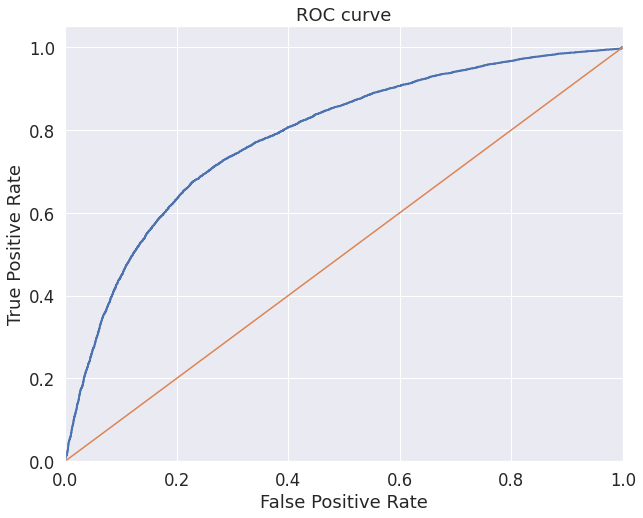

In [11]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [12]:
roc_auc_score_lr = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
log_loss_lr = log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score_lr))
print("log loss score: {}".format(log_loss_lr))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230668


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


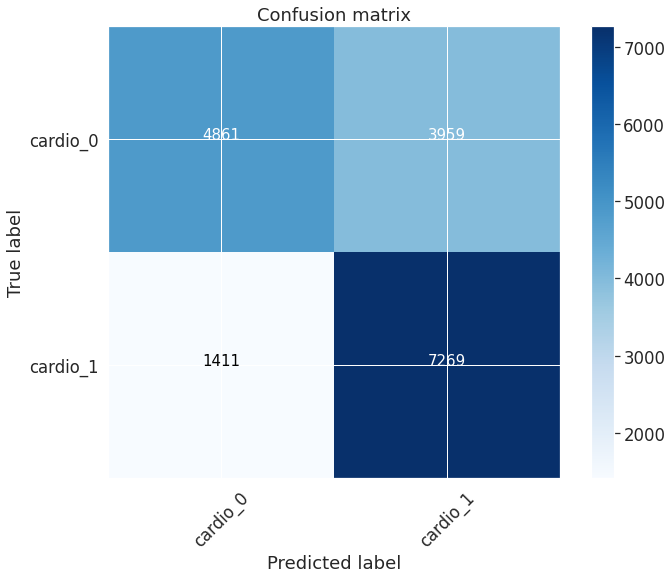

In [13]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [14]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

### Random Forest

In [15]:
classifier_tree = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores_tree = cross_val_score(classifier_tree, X_train, y_train, cv=7, scoring='roc_auc')
cv_score_tree = np.mean(cv_scores_tree)
cv_score_std_tree = np.std(cv_scores_tree)
print('CV score is {}+-{}'.format(cv_score_tree, cv_score_std_tree))

#обучим пайплайн на всем тренировочном датасете
classifier_tree.fit(X_train, y_train)
y_score_tree = classifier_tree.predict_proba(X_test)[:, 1]

CV score is 0.7743796633622809+-0.003611330100912611


In [16]:
b=2
precision_tree, recall_tree, thresholds_tree = precision_recall_curve(y_test.values, y_score_tree)
fscore_tree = (1+b**2)*(precision_tree * recall_tree) / (b**2*precision_tree + recall_tree)
# locate the index of the largest f score
ix_tree = np.argmax(fscore_tree)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_tree[ix_tree], 
                                                                        fscore_tree[ix_tree],
                                                                        precision_tree[ix_tree],
                                                                        recall_tree[ix_tree]))

Best Threshold=0.076667, F-Score=0.833, Precision=0.521, Recall=0.981


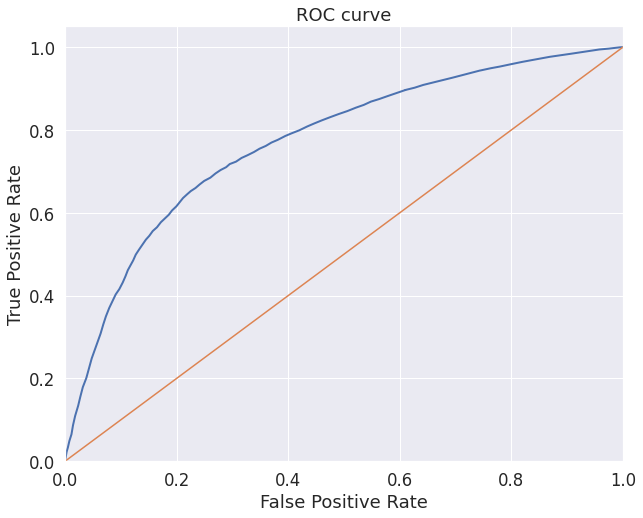

In [17]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_tree = roc_curve(y_test, y_score_tree, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [18]:
roc_auc_score_tree = roc_auc_score(y_true=y_test, y_score=classifier_tree.predict_proba(X_test)[:,1])
log_loss_tree = log_loss(y_true=y_test, y_pred=classifier_tree.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score_tree))
print("log loss score: {}".format(log_loss_tree))

roc auc score: 0.7710366181802983
log loss score: 0.5992984853728378


Confusion matrix, without normalization
[[8672  148]
 [7747  933]]


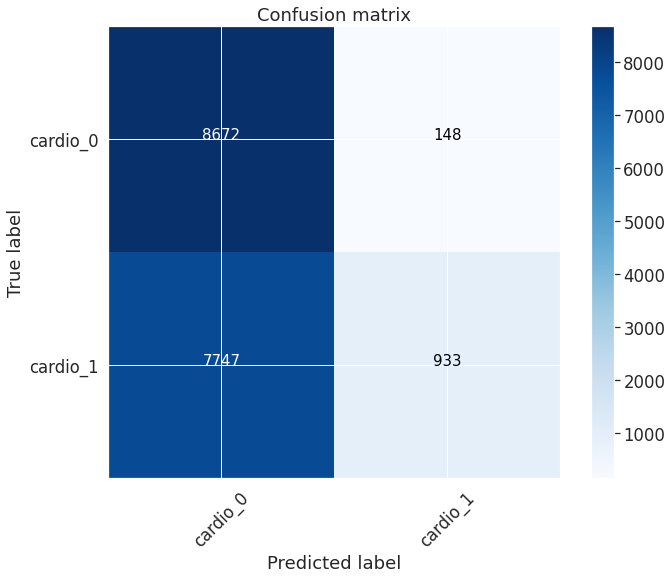

In [19]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_tree = confusion_matrix(y_test, y_score>thresholds_tree[ix_tree])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_tree, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_tree.png")
plt.show()

In [20]:
TN_tree = cnf_matrix_tree[0][0]
FN_tree = cnf_matrix_tree[1][0]
TP_tree = cnf_matrix_tree[1][1]
FP_tree = cnf_matrix_tree[0][1]

TPR_tree = TP_tree/(TP_tree+FN_tree)
FPR_tree = FP_tree/(FP_tree+TN_tree)
TNR_tree = TN_tree/(FP_tree+TN_tree)
TPR_tree, FPR_tree, TNR_tree

(0.10748847926267281, 0.016780045351473923, 0.9832199546485261)

In [21]:
classifier_ada = Pipeline([
    ('features',feats),
    ('classifier', AdaBoostClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores_ada = cross_val_score(classifier_ada, X_train, y_train, cv=7, scoring='roc_auc')
cv_score_ada = np.mean(cv_scores_ada)
cv_score_std_ada = np.std(cv_scores_ada)
print('CV score is {}+-{}'.format(cv_score_ada, cv_score_std_ada))

#обучим пайплайн на всем тренировочном датасете
classifier_ada.fit(X_train, y_train)
y_score_ada = classifier_ada.predict_proba(X_test)[:, 1]

CV score is 0.7947234142489508+-0.003603068933381472


In [22]:
b=1
precision_ada, recall_ada, thresholds_ada = precision_recall_curve(y_test.values, y_score_ada)
fscore_ada = (1+b**2)*(precision_ada * recall_ada) / (b**2*precision_ada + recall_ada)
# locate the index of the largest f score
ix_ada = np.argmax(fscore_ada)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_ada[ix_ada], 
                                                                        fscore_ada[ix_ada],
                                                                        precision_ada[ix_ada],
                                                                        recall_ada[ix_ada]))

Best Threshold=0.497430, F-Score=0.738, Precision=0.692, Recall=0.789


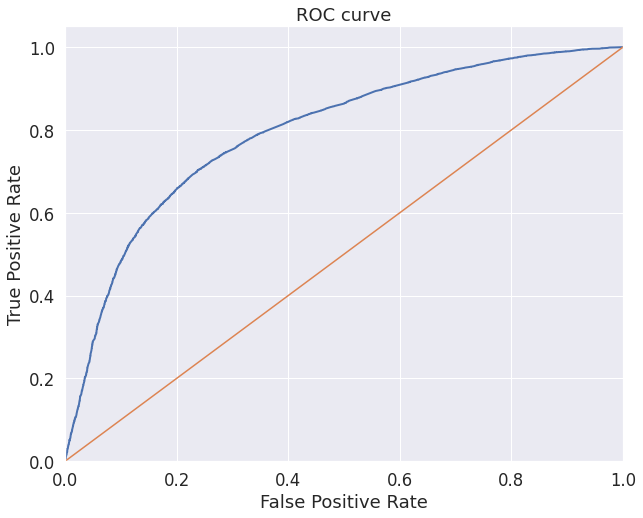

In [23]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ada = roc_curve(y_test, y_score_ada, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [24]:
roc_auc_score_ada = roc_auc_score(y_true=y_test, y_score=classifier_ada.predict_proba(X_test)[:,1])
log_loss_ada = log_loss(y_true=y_test, y_pred=classifier_ada.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score_ada))
print("log loss score: {}".format(log_loss_ada))

roc auc score: 0.7945722371129712
log loss score: 0.6869766413646277


Confusion matrix, without normalization
[[6838 1982]
 [2875 5805]]


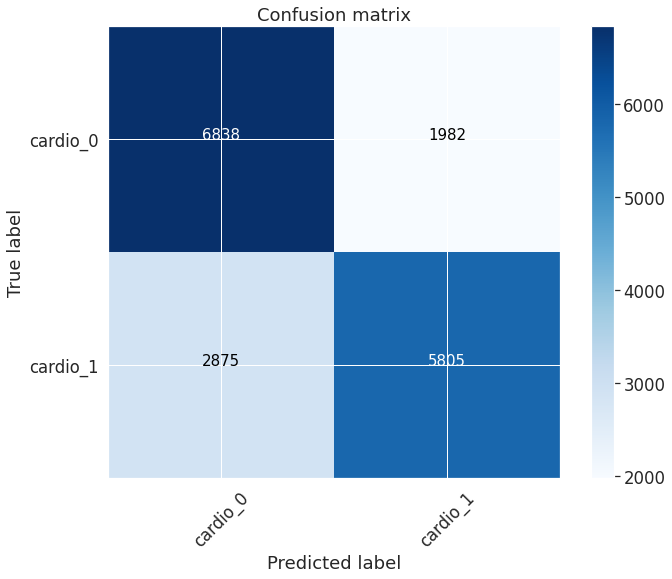

In [25]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_ada = confusion_matrix(y_test, y_score>thresholds_ada[ix_ada])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_ada, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_ada.png")
plt.show()

In [26]:
TN_ada = cnf_matrix_ada[0][0]
FN_ada = cnf_matrix_ada[1][0]
TP_ada = cnf_matrix_ada[1][1]
FP_ada = cnf_matrix_ada[0][1]

TPR_ada = TP_ada/(TP_ada+FN_ada)
FPR_ada = FP_ada/(FP_ada+TN_ada)
TNR_ada = TN_ada/(FP_ada+TN_ada)
TPR_ada, FPR_ada, TNR_ada

(0.668778801843318, 0.22471655328798185, 0.7752834467120181)

In [27]:
print(f'\t\tLogisticRegression \n')
print('F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC AUC=%.3f' % (fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix], roc_auc_score_lr))
print(f'TPR {TPR} FPR {FPR} TNR {TNR}')
print(f'\n\t\tRandomForest \n')
print('F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC AUC=%.3f' % (fscore_tree[ix_tree],
                                                                        precision_tree[ix_tree],
                                                                        recall_tree[ix_tree], roc_auc_score_tree))
print(f'TPR {TPR_tree} FPR {FPR_tree} TNR {TNR_tree}')
print(f'\n\t\tAdaBoosting \n')
print('F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC AUC=%.3f' % (fscore_ada[ix_ada],
                                                                        precision_ada[ix_ada],
                                                                        recall_ada[ix_ada], roc_auc_score_ada))
print(f'TPR {TPR_ada} FPR {FPR_ada} TNR {TNR_ada}')

		LogisticRegression 

F-Score=0.730, Precision=0.647, Recall=0.838, ROC AUC=0.784
TPR 0.837442396313364 FPR 0.44886621315192743 TNR 0.5511337868480726

		RandomForest 

F-Score=0.833, Precision=0.521, Recall=0.981, ROC AUC=0.771
TPR 0.10748847926267281 FPR 0.016780045351473923 TNR 0.9832199546485261

		AdaBoosting 

F-Score=0.738, Precision=0.692, Recall=0.789, ROC AUC=0.795
TPR 0.668778801843318 FPR 0.22471655328798185 TNR 0.7752834467120181


Делая вывод по данной работе, хочу сказать, что по моему мнению самая лучшая модель - модель обученная с помощью AdaBoosting. RandomForest выдает немного странные результаты, не понимаю почему идет такой сильный дисбаланс классов ответа.

При сильном дисбалансе классов  roc_auc_curve подходит больше, потому что True Positive Rate и False Positive Rate устойчивы при несбалансированных данных.